<a href="https://colab.research.google.com/github/mekhanikaladvantage/vneural-pdes/blob/main/Deep_Ritz_100D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Imports
'''
!pip install optax #must be run at the start of the session.

from jax import jit, grad, vmap, value_and_grad
from jax import random, nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import math

# JAX_DEBUG_NANS=True
JAX_DEBUG_NANS = False
from jax.config import config
# config.update("jax_debug_nans",True)
config.update("jax_debug_nans",False)
config.parse_flags_with_absl()

#set 64 bit precision
# JAX_ENABLE_X64=True
JAX_ENABLE_X64=False

%xmode context
# %xmode verbose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Exception reporting mode: Context


Hyperparameters
==========

In [ ]:
#set hyperparameters

# this creates random parameters for the weights and biases of a given node
def random_layer_params(m:int,n:int,key, scale = 1e-2) -> tuple:
    '''
    currenly using the normalized Bengio-Glorot initialization.
    '''
    w_key, b_key = random.split(key)
    # return scale * random.normal(w_key,(n,m)), scale * random.normal(b_key,(n,1))
    minval = -6/(jnp.sqrt(m + n)) 
    # minval = 1
    maxval = -1*minval
    # maxval = 2
    w = scale * random.uniform(w_key,(n,m),minval = minval,maxval = maxval) #n x m
    b = scale * random.uniform(b_key,(n,),minval = minval,maxval = maxval) # vector of length n, 1 dimensional.
    return w,b 

# this should initalize nodes
def init_network_params(sizes:list,key) -> list:
    keys = random.split(key, len(sizes))
    return [random_layer_params(m,n,k) for m,n,k in zip(sizes[:-1],sizes[1:],keys)]


hypers = dict()
hypers["d"] = 100 #specified in exp
hypers["m"] = 100 # specified in exp
# hypers["m"] = 200
# hypers["m"] = 400
hypers["step size"] = 2e-04
hypers["num epochs"] = 50000 # specified in experiment
# hypers["num epochs"] = int(1e5)
hypers["batch size"] = 1000 #specified in experiement
hypers["boundary size"] = 100 #specified in experiment
# hypers['boundary size'] = 50
hypers["beta"] = 10**3 # specfified in experiment

layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],1]
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],1] # 1 hidden layer
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],1] #2 hidden layers
# layer_sizes = [hypers["d"],hypers["m"],1]

params = init_network_params(layer_sizes,random.PRNGKey(0))
# params = init_network_params(layer_sizes,subkey)


# key, subkey = random.split(key) #this enables us to not fix the initial parameters

optimizer = optax.adam(learning_rate = hypers["step size"])



Model
=====

In [ ]:
from jaxlib.xla_extension import DeviceArray
compiled_celu = jit(nn.celu)
compiled_softplus = jit(nn.softplus)


def relu(x) -> np.float32:
  return jnp.maximum(0,x**3) #propogates NaNs

def model(params:list,x:DeviceArray) -> np.float32:
    # print("shape of input is {}".format(x.shape))
    '''
    params: list of weight, bias tuples. 
    x: Input vector. Should be shape (10,)
    '''

    w,b = params[0]
    # print(w.shape)
    output = jnp.dot(w,x) + b
    # print(f'shape of activations is {output.shape}')
    activations = relu(output)
    #relu propogates nans
    residual = activations #will be used for skip connection, needs right dim
    #evenness counter
    layer_number = 1
    i = 0
    # print("activations before lin transform is {}".format(activations))
    
    for w,b in params[1:-1]: #first and last params are for linear transformation
        # output = jnp.add(jnp.dot(w,activations),b)
        output = jnp.dot(w,activations) + b
        # print("output of transform before relu is {}".format(output))
        
        activations = relu(output)
        
        # print(f'activation shape: \n {activations.shape}')
        if i%2 == 0: #only have skip connection on even blocks
            activations += residual #add skip connection
            residual = activations #update residual
            # print(f'skip after layer {layer_number}')
        layer_number += 1
        i += 1
        # # # print("activations after transform is {}".format(activations))
        
    final_w,final_b = params[-1] 
    logits = jnp.dot(final_w,activations) + final_b
    return logits[0]


    #######

batched_model = vmap(model,in_axes=(None,0)) 

In [ ]:
# model debugging
x = jnp.ones(shape=(100,))
# print(x.shape)
out = model(params,x) # 0.004663214
print(out)

0.0047450485


Batching
========
The domain is $(0,1)^{100}$, and the boundary is thus $\partial(0,1)^{100}$. I need to figure out how to sample from all of the hyperplanes, and there are a lot. 

In [ ]:
'''
Batching
'''
key, subkey = random.split(random.PRNGKey(0))
#  #need static argums batch dim size

nudge = jnp.finfo(np.float32).tiny
# print(nudge)


def get_batch(batch_size:int,key:DeviceArray) -> DeviceArray:
  return random.uniform(key,shape = (batch_size,hypers["d"]),minval=jnp.nextafter(0,jnp.inf),maxval=1)
  # nextafter necessary since uniform samples [minval,maxval). We want (minval,maxval).



ones = jnp.ones(shape=(hypers["boundary size"],))
zeros = jnp.zeros(shape=(hypers["boundary size"],))


def get_boundary_batch(bdy_batch_size:int,key:DeviceArray) -> DeviceArray:
  keys = random.split(key,num=3)
  # we have two extra keys bc we need them for sampling
  samples = [] 
  bdy_planes = [] #will keep every boundary section in a list
  # and then concatenate everything together
  high_end = jnp.nextafter(1,jnp.inf)

  for i in range(hypers["d"]):
    sample_1 = random.uniform(keys[0],shape=(bdy_batch_size,hypers["d"]-1),minval=0,maxval=high_end) #batch_size x 9
    bdy_with_ones = jnp.column_stack((sample_1[:,:i],ones,sample_1[:,i:]))
    bdy_planes.append(bdy_with_ones)
    # print(bdy_planes)

    sample_0 = random.uniform(keys[1],shape=(bdy_batch_size,hypers["d"] - 1),minval=0,maxval=high_end)
    bdy_with_zeros = jnp.column_stack((sample_0[:,:i],zeros,sample_0[:,i:]))
    bdy_planes.append(bdy_with_zeros)

    keys = random.split(keys[-1],num=3)
  #end

  return jnp.concatenate(bdy_planes[:],axis=0)



# ones = jnp.ones(shape=(4,))
# zeros = jnp.zeros(shape=(4),)
# boundary = get_boundary_batch(hypers["boundary size"],subkey)
# interior = get_batch(4,subkey)
# print(interior)
# print(boundary[395:405])
# print(f'shape of boundary is {boundary.shape}')

In [ ]:
'''
testing block - batching
'''
x = jnp.ones(shape=(10,10))
y = jnp.zeros(shape=(10,))
z = [x, y]
# delta = jnp.concatenate(z[:],axis=0)
stacks = []
print()
for i in range(len(x[0]) + 1):
  stack = jnp.column_stack((x[:,:i],y,x[:,i:]))
  stacks.append(stack)

output = jnp.concatenate(stacks[:],axis=0)
print(output[50:60,:])


[[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]]


Loss and Update
=====

In [ ]:
'''
loss and update block
'''

from optax._src.base import OptState
from chex._src.pytypes import Device
from jax._src.random import KeyArray

def exact(x:DeviceArray) -> np.float32:
  #this function doubles as the boundary condition and also the exact solution to the problem. 
  return sum(x*x)

exact_vector = vmap(exact,in_axes=0)

def flow_loss_fn(params:list,x:DeviceArray) -> np.float32:
  '''
  flow loss calculated on 1 2D sample in order to have scalar output.
  The scalar output of the model necessary for autograd to work.
  '''
  dudx = grad(model,argnums=1)(params,x) # compute gradient wrt sample
  # print(f'shape of gradient is {dudx.shape}')
  # print(f'gradient is {dudx}')
  # print(f'gradient squared is {dudx*dudx}')
  return 0.5*(jnp.sum(dudx*dudx) + 200*model(params,x)) #since f = -200
  

flow_loss_vector = vmap(flow_loss_fn,in_axes=(None,0)) 

def loss_fn(params:list,key:KeyArray) -> np.float32:
# def loss_fn(params:list,interior_sample,boundary_sample):
  '''
  this function samples data and calculates the loss.
  Please note that this function MUST be differentiable.
  The loss consists of two parts, an flow loss given by the energy,
  and a boundary loss to enforce boundary conditions. 
  '''
  # generate data
  keys = random.split(key,num=2)
  interior_sample = get_batch(hypers["batch size"],keys[0])
  boundary_sample = get_boundary_batch(hypers["boundary size"],keys[1])
  
  #calculate flow loss
  flow_output = flow_loss_vector(params,interior_sample)
  flow_loss = jnp.mean(flow_output) 

  #calculate boundary loss
  # bdy_loss = beta*jnp.mean(batched_model(params,boundary_sample)*batched_model(params,boundary_sample))
  bdy_output = batched_model(params,boundary_sample)
  exact_output = exact_vector(boundary_sample)
  bdy_diff = exact_output - bdy_output
  # print(f'bdy_diff is {bdy_diff}')
  bdy_loss = hypers["beta"]*jnp.mean(bdy_diff*bdy_diff)

  return jnp.add(flow_loss,bdy_loss)

def update(params:list,opt_state:OptState,key:KeyArray):
# def update(params:list,opt_state:OptState,interior_sample,boundary_sample):
  '''
  This calculates the parameter updates using the ADAM algorithm,
  as implemented in optax.
  '''

  loss,grads = value_and_grad(loss_fn,argnums=0)(params,key)
  # loss,grads = value_and_grad(loss_fn,argnums=0)(params,interior_sample,boundary_sample)

  updates,opt_state = optimizer.update(grads,opt_state,params)
  params = optax.apply_updates(params,updates)

  return params,opt_state,loss

#jit update for moar speed
compiled_update = jit(update)

In [ ]:
'''
debugging block - loss and update
'''
# x = 2*jnp.ones(shape=(10,10))
# y = loss_fn(params,random.PRNGKey(2))
# print(y) # should be 5 

'\ndebugging block - loss and update\n'

Training Loop
===========

In [ ]:
#reset key
key, train_key = random.split(random.PRNGKey(0))
params = init_network_params(layer_sizes,train_key)

%xmode context
# %xmode verbose


Exception reporting mode: Context


---------------
Epoch 0 in 27.97 additional seconds
Interior relative error is 0.9998473525047302
Boundary relative error is 0.9998477697372437
Total loss is 1.1297e+06
---------------
Epoch 500 in 4.10 additional seconds
Interior relative error is 0.9718774557113647
Boundary relative error is 0.9718672633171082
Total loss is 1.0682e+06
---------------
Epoch 1000 in 4.03 additional seconds
Interior relative error is 0.9696247577667236
Boundary relative error is 0.969631552696228
Total loss is 1.0629e+06
---------------
Epoch 1500 in 4.13 additional seconds
Interior relative error is 0.9665240049362183
Boundary relative error is 0.966647207736969
Total loss is 1.0557e+06
---------------
Epoch 2000 in 4.06 additional seconds
Interior relative error is 0.9624979496002197
Boundary relative error is 0.9627506732940674
Total loss is 1.0508e+06
---------------
Epoch 2500 in 4.16 additional seconds
Interior relative error is 0.958233654499054
Boundary relative error is 0.9582459330558777
Total

<Figure size 432x288 with 0 Axes>

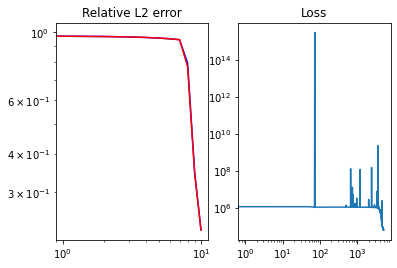

---------------
Epoch 5500 in 5.15 additional seconds
Interior relative error is 0.20618924498558044
Boundary relative error is 0.21425335109233856
Total loss is 5.5887e+04
---------------
Epoch 6000 in 4.15 additional seconds
Interior relative error is 0.18235881626605988
Boundary relative error is 0.18537482619285583
Total loss is 4.2681e+04
---------------
Epoch 6500 in 4.22 additional seconds
Interior relative error is 0.12405689060688019
Boundary relative error is 0.12694476544857025
Total loss is 2.1848e+04
---------------
Epoch 7000 in 4.17 additional seconds
Interior relative error is 0.10948339849710464
Boundary relative error is 0.11195973306894302
Total loss is 1.7817e+04
---------------
Epoch 7500 in 4.19 additional seconds
Interior relative error is 0.11043604463338852
Boundary relative error is 0.10138256102800369
Total loss is 1.5130e+04
---------------
Epoch 8000 in 4.20 additional seconds
Interior relative error is 0.09135104715824127
Boundary relative error is 0.08860

<Figure size 432x288 with 0 Axes>

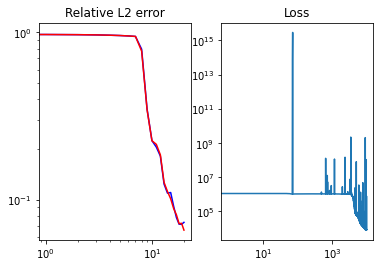

---------------
Epoch 10500 in 5.01 additional seconds
Interior relative error is 0.05811481177806854
Boundary relative error is 0.05784539133310318
Total loss is 7.1993e+03
---------------
Epoch 11000 in 4.20 additional seconds
Interior relative error is 0.0484028197824955
Boundary relative error is 0.05220040678977966
Total loss is 6.4972e+03
---------------
Epoch 11500 in 4.20 additional seconds
Interior relative error is 0.047507088631391525
Boundary relative error is 0.04798742011189461
Total loss is 5.9981e+03
---------------
Epoch 12000 in 4.29 additional seconds
Interior relative error is 0.04448669031262398
Boundary relative error is 0.044468097388744354
Total loss is 5.6364e+03
---------------
Epoch 12500 in 4.19 additional seconds
Interior relative error is 0.04238679260015488
Boundary relative error is 0.04308398813009262
Total loss is 5.4930e+03
---------------
Epoch 13000 in 4.28 additional seconds
Interior relative error is 0.04181281104683876
Boundary relative error is 

<Figure size 432x288 with 0 Axes>

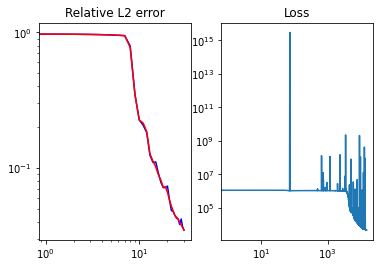

---------------
Epoch 15500 in 5.10 additional seconds
Interior relative error is 0.03364571928977966
Boundary relative error is 0.03309125453233719
Total loss is 4.6518e+03
---------------
Epoch 16000 in 4.27 additional seconds
Interior relative error is 0.032773397862911224
Boundary relative error is 0.032380275428295135
Total loss is 4.5887e+03
---------------
Epoch 16500 in 4.20 additional seconds
Interior relative error is 0.030705681070685387
Boundary relative error is 0.031300630420446396
Total loss is 4.5082e+03
---------------
Epoch 17000 in 4.27 additional seconds
Interior relative error is 0.029472921043634415
Boundary relative error is 0.030235854908823967
Total loss is 4.4303e+03
---------------
Epoch 17500 in 4.20 additional seconds
Interior relative error is 0.033889640122652054
Boundary relative error is 0.03314783424139023
Total loss is 4.6431e+03
---------------
Epoch 18000 in 4.28 additional seconds
Interior relative error is 0.02703602984547615
Boundary relative err

<Figure size 432x288 with 0 Axes>

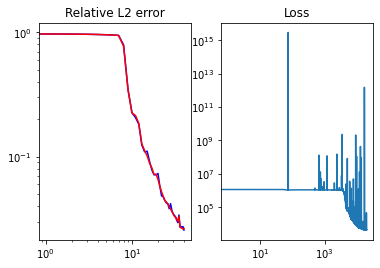

---------------
Epoch 20500 in 5.25 additional seconds
Interior relative error is 0.02700011618435383
Boundary relative error is 0.02590452879667282
Total loss is 4.1564e+03
---------------
Epoch 21000 in 4.19 additional seconds
Interior relative error is 0.026199445128440857
Boundary relative error is 0.025745783001184464
Total loss is 4.1389e+03
---------------
Epoch 21500 in 4.19 additional seconds
Interior relative error is 0.02576950006186962
Boundary relative error is 0.025381339713931084
Total loss is 4.1181e+03
---------------
Epoch 22000 in 4.20 additional seconds
Interior relative error is 0.025481510907411575
Boundary relative error is 0.025478731840848923
Total loss is 4.1539e+03
---------------
Epoch 22500 in 4.20 additional seconds
Interior relative error is 0.026355428621172905
Boundary relative error is 0.02487260103225708
Total loss is 4.0916e+03
---------------
Epoch 23000 in 4.20 additional seconds
Interior relative error is 0.025499533861875534
Boundary relative err

<Figure size 432x288 with 0 Axes>

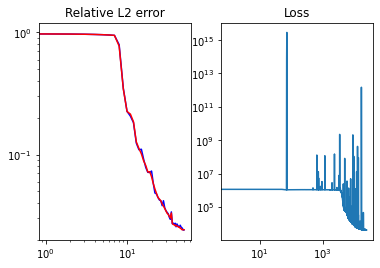

---------------
Epoch 25500 in 5.13 additional seconds
Interior relative error is 0.024085624143481255
Boundary relative error is 0.023807181045413017
Total loss is 4.0215e+03
---------------
Epoch 26000 in 4.19 additional seconds
Interior relative error is 0.024003995582461357
Boundary relative error is 0.023798441514372826
Total loss is 4.0209e+03
---------------
Epoch 26500 in 4.19 additional seconds
Interior relative error is 0.02388848178088665
Boundary relative error is 0.023679329082369804
Total loss is 4.0286e+03
---------------
Epoch 27000 in 4.21 additional seconds
Interior relative error is 0.024681350216269493
Boundary relative error is 0.023695342242717743
Total loss is 4.0342e+03
---------------
Epoch 27500 in 4.29 additional seconds
Interior relative error is 0.025071313604712486
Boundary relative error is 0.023770367726683617
Total loss is 4.0401e+03
---------------
Epoch 28000 in 4.20 additional seconds
Interior relative error is 0.023714909330010414
Boundary relative 

<Figure size 432x288 with 0 Axes>

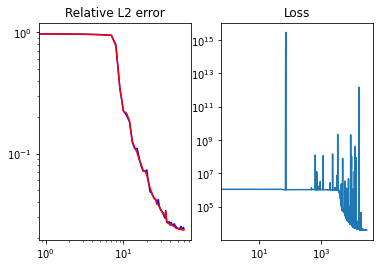

---------------
Epoch 30500 in 5.37 additional seconds
Interior relative error is 0.02489391714334488
Boundary relative error is 0.023210572078824043
Total loss is 4.0033e+03
---------------
Epoch 31000 in 4.20 additional seconds
Interior relative error is 0.024265779182314873
Boundary relative error is 0.02347869984805584
Total loss is 3.9968e+03
---------------
Epoch 31500 in 4.27 additional seconds
Interior relative error is 0.024146676063537598
Boundary relative error is 0.02348078042268753
Total loss is 4.0090e+03
---------------
Epoch 32000 in 4.20 additional seconds
Interior relative error is 0.0238393172621727
Boundary relative error is 0.023349694907665253
Total loss is 4.0034e+03
---------------
Epoch 32500 in 4.28 additional seconds
Interior relative error is 0.023692511022090912
Boundary relative error is 0.023484906181693077
Total loss is 4.0168e+03
---------------
Epoch 33000 in 4.20 additional seconds
Interior relative error is 0.024093329906463623
Boundary relative erro

<Figure size 432x288 with 0 Axes>

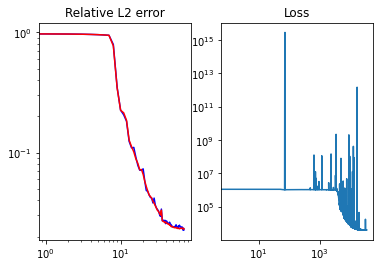

---------------
Epoch 35500 in 5.90 additional seconds
Interior relative error is 0.023719491437077522
Boundary relative error is 0.023249559104442596
Total loss is 4.0101e+03
---------------
Epoch 36000 in 4.19 additional seconds
Interior relative error is 0.02409120462834835
Boundary relative error is 0.023366939276456833
Total loss is 4.0082e+03
---------------
Epoch 36500 in 4.28 additional seconds
Interior relative error is 0.02363554947078228
Boundary relative error is 0.023336878046393394
Total loss is 4.0041e+03
---------------
Epoch 37000 in 4.19 additional seconds
Interior relative error is 0.023241190239787102
Boundary relative error is 0.02322627790272236
Total loss is 4.0050e+03
---------------
Epoch 37500 in 4.20 additional seconds
Interior relative error is 0.023714328184723854
Boundary relative error is 0.02304302155971527
Total loss is 3.9940e+03
---------------
Epoch 38000 in 4.20 additional seconds
Interior relative error is 0.02439923956990242
Boundary relative erro

<Figure size 432x288 with 0 Axes>

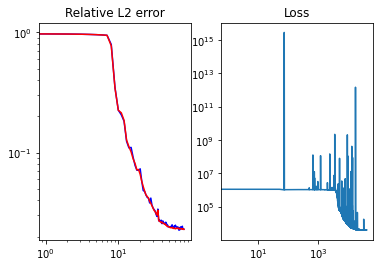

---------------
Epoch 40500 in 5.28 additional seconds
Interior relative error is 0.02370537258684635
Boundary relative error is 0.02307206019759178
Total loss is 3.9912e+03
---------------
Epoch 41000 in 4.19 additional seconds
Interior relative error is 0.022246237844228745
Boundary relative error is 0.02326601929962635
Total loss is 4.0208e+03
---------------
Epoch 41500 in 4.19 additional seconds
Interior relative error is 0.022786978632211685
Boundary relative error is 0.023005692288279533
Total loss is 4.0013e+03
---------------
Epoch 42000 in 4.19 additional seconds
Interior relative error is 0.023437386378645897
Boundary relative error is 0.02294991910457611
Total loss is 3.9969e+03
---------------
Epoch 42500 in 4.19 additional seconds
Interior relative error is 0.022380109876394272
Boundary relative error is 0.022998157888650894
Total loss is 3.9857e+03
---------------
Epoch 43000 in 4.20 additional seconds
Interior relative error is 0.02365216426551342
Boundary relative erro

<Figure size 432x288 with 0 Axes>

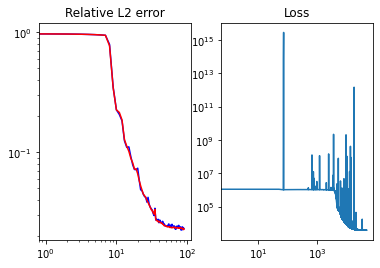

---------------
Epoch 45500 in 5.38 additional seconds
Interior relative error is 0.022747697308659554
Boundary relative error is 0.022438401356339455
Total loss is 3.9561e+03
---------------
Epoch 46000 in 4.26 additional seconds
Interior relative error is 0.023280343040823936
Boundary relative error is 0.022453000769019127
Total loss is 3.9605e+03
---------------
Epoch 46500 in 4.20 additional seconds
Interior relative error is 0.021682163700461388
Boundary relative error is 0.022075582295656204
Total loss is 3.9376e+03
---------------
Epoch 47000 in 4.28 additional seconds
Interior relative error is 0.02314160205423832
Boundary relative error is 0.022039124742150307
Total loss is 3.9403e+03
---------------
Epoch 47500 in 4.20 additional seconds
Interior relative error is 0.02220986597239971
Boundary relative error is 0.022167261689901352
Total loss is 3.9340e+03
---------------
Epoch 48000 in 4.29 additional seconds
Interior relative error is 0.022864624857902527
Boundary relative e

In [ ]:
#training loop
import time

flow_losses = []
bdy_losses = []
training_losses = []
flow_residuals = []
bdy_residuals = []

# i=1
# num_epochs = int(1e5) #run for longer
num_epochs = 50000
# num_epochs = 75000
#adam optimizer via optax
opt_state = optimizer.init(params)
start_time = time.time()

for epoch in range(hypers["num epochs"]):
    
    key,train_key = random.split(key)
    
    
    params,opt_state,train_loss = compiled_update(params,opt_state,train_key)
    # params,opt_state,train_loss = compiled_error_update(params,opt_state,train_key)

    # loss = jnp.add(int_loss,bdy_loss)
    training_losses.append(train_loss)
    
    if epoch%500 == 0:
      

      epoch_time = time.time() - start_time

      keys = random.split(train_key,num=2)
      int_out_batch = get_batch(hypers["batch size"],keys[0])
      bdy_out_batch = get_boundary_batch(hypers["boundary size"],keys[1])

      flow_output = flow_loss_vector(params,int_out_batch)
      flow_train_loss = jnp.mean(flow_output)
      flow_losses.append(flow_train_loss)

      bdy_output = batched_model(params,bdy_out_batch)
      exact_bdy = exact_vector(bdy_out_batch)
      bdy_diff = bdy_output - exact_bdy
      bdy_train_loss = hypers["beta"]*jnp.mean(bdy_diff*bdy_diff)
      bdy_losses.append(bdy_train_loss)
      bdy_error = jnp.sqrt(jnp.mean(bdy_diff*bdy_diff) / jnp.mean(exact_bdy**2)) #don't need penalty param here
      # bdy_error = jnp.sqrt(jnp.sum(bdy_diff*bdy_diff) / jnp.sum(exact_bdy**2)) #don't need penalty param here
      bdy_residuals.append(bdy_error)

      exact_int = exact_vector(int_out_batch)
      int_output = batched_model(params,int_out_batch)
      int_error = jnp.sqrt(jnp.mean((exact_int - int_output)**2)/jnp.mean(exact_int**2))
      # int_error = jnp.sqrt(jnp.sum((exact_int - int_output)**2)/jnp.sum(exact_int**2)) 
      #error is measured in relative L2 error
      flow_residuals.append(int_error)

      start_time = time.time()
      print("---------------")
      print("Epoch {} in {:0.2f} additional seconds".format(epoch, epoch_time))
      
      print(f'Interior relative error is {int_error}')
      print(f'Boundary relative error is {bdy_error}')
      train_loss_sci = np.format_float_scientific(train_loss, precision=4, unique=False)
      print("Total loss is {}".format(train_loss_sci))
    #end if

    if epoch%5000 == 0 and epoch != 0:
      plt.clf()
      fig,axs = plt.subplots(nrows=1,ncols=2)
      axs[0].loglog(flow_residuals,'b')
      axs[0].loglog(bdy_residuals,'r')
      axs[0].set_title("Relative L2 error")
      axs[1].loglog(training_losses)
      # axs[1].loglog(,'r')
      axs[1].set_title("Loss")
      plt.show()
    #end if

#end for
    
#once loops ends    
print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time)) #print final epoch info
print("Final loss is  {}".format(train_loss))



final flow residual error is 0.02316792495548725
final boundary residual error is 0.022114023566246033
intial error is 1.999695062637329
total final error is 0.045281946659088135
reduction in error is 1.9544131755828857


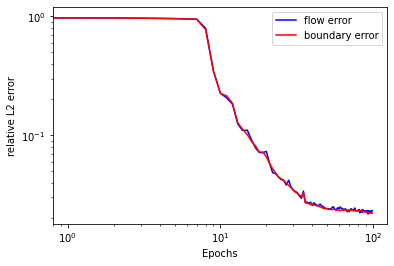

In [ ]:
plt.clf()
plt.loglog(flow_residuals,'b',label="flow error")
plt.loglog(bdy_residuals,'r',label = 'boundary error')
plt.xlabel("Epochs")
plt.ylabel("relative L2 error")
plt.legend()
# plt.show()
plt.savefig("100d-resnet-error.png")
print(f'final flow residual error is {flow_residuals[-1]}')
print(f'final boundary residual error is {bdy_residuals[-1]}')
print(f'intial error is { jnp.add(flow_residuals[0],bdy_residuals[0])}')
print(f'total final error is {jnp.add(flow_residuals[-1],bdy_residuals[-1])}')
error_reduction = jnp.add(flow_residuals[0],bdy_residuals[0]) - jnp.add(flow_residuals[-1],bdy_residuals[-1])
print(f'reduction in error is {error_reduction}')

Reduction in loss: 1125707.25


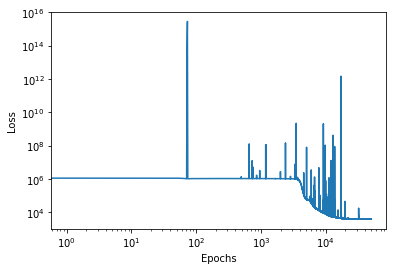

In [ ]:
plt.clf()
plt.loglog(training_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("100D-ff-loss.png")
print(f'Reduction in loss: {training_losses[0] - training_losses[-1]}')

In [ ]:
# print(min(training_losses))